In [9]:
# Imports here
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 
from torch.utils.tensorboard import SummaryWriter 

from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter



In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **Steps**

Step 1: Load Dataset <p>
Step 2: Transform the Dataset <p>
Step 3: Create Model <p>
Step 4: Train Model <p>
Step 5: Save the Model <p>
Step 6: Load the Model <p>


# Step 1: Load Dataset



In [11]:
data_dir = './dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Step 2: Transform the Dataset

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [13]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root=valid_dir, transform=test_transforms)
validloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

# Step 3: Create Model



In [14]:
import torch
import torch.nn as nn
import torchvision
# Initialization of Weights: The weights are initialized directly as nn.Parameter without any initialization method being specified. It is usually better to use a specific weight initialization method, like nn.init.kaiming_uniform_ or nn.init.xavier_uniform_.

# Offset Convolutions: In deformable convolutions, the offsets are learned parameters. By creating a convolution layer to predict these offsets, you're on the right track. Ensure the output channel size of the offset convolution matches the number of offsets needed for the corresponding deformable convolution.

# Bias Terms: You have not specified biases for the convolutional layers. Deformable convolutions can include a bias term, so you may want to define them as nn.Parameter as well, if desired.

# Pooling Layer After Deformable Convolution: After the second deformable convolution, you apply the pooling operation. Make sure this aligns with your intended model architecture, as pooling operations reduce spatial dimensions, potentially affecting the performance of subsequent deformable convolutions.

# Dimensionality of the Fully Connected Layer: You need to ensure that the output dimension before flattening (128 * 56 * 56) matches the input dimensionality of self.fc1. This might not be correct depending on your input size and the effect of your deformable convolutions and pooling layers on the spatial dimensions of the feature maps. You'll need to calculate the exact size based on the model's architecture and the input image size.


class DeformableCNNModel(nn.Module):
    def __init__(self):
        super(DeformableCNNModel, self).__init__()

        # Convolutional weights
        self.weight1 = nn.Parameter(torch.Tensor(32, 3, 3, 3))
        self.weight2 = nn.Parameter(torch.Tensor(64, 32, 3, 3))
        self.weight3 = nn.Parameter(torch.Tensor(128, 64, 3, 3))
        nn.init.kaiming_uniform_(self.weight1, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.weight2, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.weight3, nonlinearity='relu')

        # Bias terms (if you want to include biases)
        self.bias1 = nn.Parameter(torch.Tensor(32))
        self.bias2 = nn.Parameter(torch.Tensor(64))
        self.bias3 = nn.Parameter(torch.Tensor(128))
        self.bias1.data.fill_(0)
        self.bias2.data.fill_(0)
        self.bias3.data.fill_(0)

        # Offset (and mask if required) for deformable convolution
        self.offsets1 = nn.Conv2d(3, 2*3*3, kernel_size=3, padding=1, stride=1)
        self.offsets2 = nn.Conv2d(32, 2*3*3, kernel_size=3, padding=1, stride=1)
        self.offsets3 = nn.Conv2d(64, 2*3*3, kernel_size=3, padding=1, stride=1)
        
        # Rest of the model remains similar
        self.pool = nn.MaxPool2d(2, 2)
        # Calculate correct size for the fully connected layer
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 102)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torchvision.ops.deform_conv2d(x, self.offsets1(x), self.weight1, self.bias1, padding=1)
        x = self.relu(x)
        
        x = self.pool(x)
        x = torchvision.ops.deform_conv2d(x, self.offsets2(x), self.weight2, self.bias2, padding=1)
        x = self.relu(x)
        
        x = self.pool(x)
        x = torchvision.ops.deform_conv2d(x, self.offsets3(x), self.weight3, self.bias3, padding=1)
        x = self.relu(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [15]:
model = DeformableCNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Model instantiation and dummy input
model_test = DeformableCNNModel()
input_test = torch.randn(64, 3, 224, 224)  # Random input tensor

# Forward pass
output_test = model_test(input_test)
print(output_test.shape)


torch.Size([64, 102])


# Step 4: Train Model

In [18]:
import pandas as pd

# Number of training epochs
num_epochs = 100
writer = SummaryWriter()

train_losses = []  # To store training losses
train_accuracies = []  # To store training accuracies
valid_losses = []  # To store validation losses
valid_accuracies = []  # To store validation accuracies

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    valid_loss = 0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(valid_loss / len(validloader))
    valid_accuracies.append(valid_accuracy)

    print(f"Validation Loss: {valid_loss / len(validloader):.4f}, Validation Accuracy: {valid_accuracy:.2f}%")

# After the training loop
df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accuracies,
    'Validation Loss': valid_losses,
    'Validation Accuracy': valid_accuracies
})

# Save the DataFrame to a CSV file
csv_file = 'Results/deform.csv'
df.to_csv(csv_file, index=False)

print(f'Training data saved to {csv_file}')


Epoch 1/100, Training Loss: 10.6201, Training Accuracy: 5.49%
Validation Loss: 3.8554, Validation Accuracy: 10.39%
Epoch 2/100, Training Loss: 3.8160, Training Accuracy: 10.10%
Validation Loss: 3.4712, Validation Accuracy: 16.38%
Epoch 3/100, Training Loss: 3.4641, Training Accuracy: 15.58%
Validation Loss: 3.1473, Validation Accuracy: 19.19%
Epoch 4/100, Training Loss: 3.2295, Training Accuracy: 19.41%
Validation Loss: 3.0336, Validation Accuracy: 23.72%
Epoch 5/100, Training Loss: 3.0720, Training Accuracy: 23.12%
Validation Loss: 3.1369, Validation Accuracy: 27.02%
Epoch 6/100, Training Loss: 2.9351, Training Accuracy: 26.10%
Validation Loss: 2.7007, Validation Accuracy: 31.91%
Epoch 7/100, Training Loss: 2.7922, Training Accuracy: 28.24%
Validation Loss: 2.5954, Validation Accuracy: 34.47%
Epoch 8/100, Training Loss: 2.6955, Training Accuracy: 30.71%
Validation Loss: 2.3859, Validation Accuracy: 39.98%
Epoch 9/100, Training Loss: 2.5969, Training Accuracy: 32.92%
Validation Loss: 2

In [19]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [20]:
correct = 0
total = 0

with torch.no_grad():
    for data in validloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = model(inputs)
        # Remove the reshaping line if it's not needed
        # outputs = outputs.view(inputs.shape[0], -1)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))


Accuracy of the network on the 818 test images: 73 %


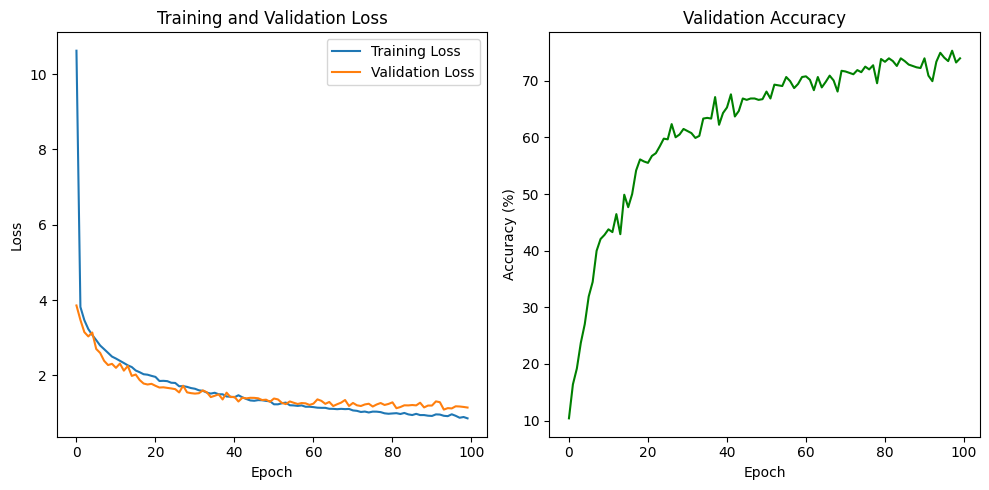

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

# Step 5: Save the Model

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: image_datasets['train'].class_to_idx. You can attach this to the model as an attribute which makes inference easier later on.

model.class_to_idx = image_datasets['train'].class_to_idx

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, optimizer.state_dict. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:


torch.save(model,'./deform.pth')

Raw Prediction (Numeric Label): 93
Predicted Label: 91
Raw Prediction (Numeric Label): 93
Predicted Label: 91
Raw Prediction (Numeric Label): 88
Predicted Label: 87
Raw Prediction (Numeric Label): 93
Predicted Label: 91
Raw Prediction (Numeric Label): 93
Predicted Label: 91


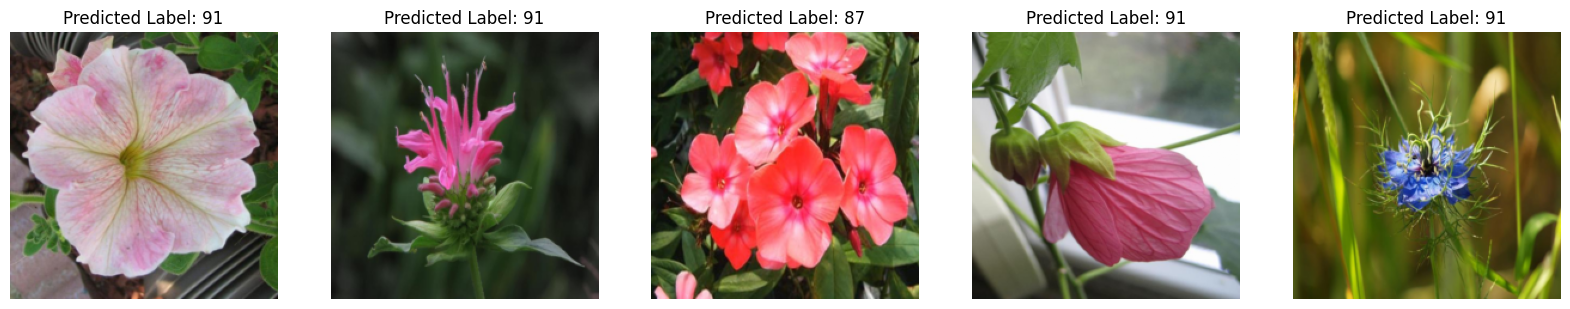

In [25]:
import os
import random
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Define the directory path for the test images
test_dir = 'dataset/test'

# List all the image files in the test directory
image_files = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir) if filename.endswith(('.jpg', '.png', '.jpeg'))]

# Randomly select 5 images
random_images = random.sample(image_files, 5)

# Create a subplot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Symbol mapping
Symbol_Map_to_id = {
    0: "1",
    1: "10",
    2: "100",
    3: "101",
    4: "102",
    5: "11",
    6: "12",
    7: "13",
    8: "14",
    9: "15",
    10: "16",
    11: "17",
    12: "18",
    13: "19",
    14: "2",
    15: "20",
    16: "21",
    17: "22",
    18: "23",
    19: "24",
    20: "25",
    21: "26",
    22: "27",
    23: "28",
    24: "29",
    25: "3",
    26: "30",
    27: "31",
    28: "32",
    29: "33",
    30: "34",
    31: "35",
    32: "36",
    33: "37",
    34: "38",
    35: "39",
    36: "4",
    37: "40",
    38: "41",
    39: "42",
    40: "43",
    41: "44",
    42: "45",
    43: "46",
    44: "47",
    45: "48",
    46: "49",
    47: "5",
    48: "50",
    49: "51",
    50: "52",
    51: "53",
    52: "54",
    53: "55",
    54: "56",
    55: "57",
    56: "58",
    57: "59",
    58: "6",
    59: "60",
    60: "61",
    61: "62",
    62: "63",
    63: "64",
    64: "65",
    65: "66",
    66: "67",
    67: "68",
    68: "69",
    69: "7",
    70: "70",
    71: "71",
    72: "72",
    73: "73",
    74: "74",
    75: "75",
    76: "76",
    77: "77",
    78: "78",
    79: "79",
    80: "8",
    81: "80",
    82: "81",
    83: "82",
    84: "83",
    85: "84",
    86: "85",
    87: "86",
    88: "87",
    89: "88",
    90: "89",
    91: "9",
    92: "90",
    93: "91",
    94: "92",
    95: "93",
    96: "94",
    97: "95",
    98: "96",
    99: "97",
    100: "98",
    101: "99"
}

# You need to define the 'transform' for preprocessing images and the 'device' for the model.
# Make sure to load your model before using it.

# Example transform:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Example device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display an image with its predicted class
# Function to display an image with its predicted class
def display_image(image_path, ax):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Apply the same transformations

    # Load your model here and define it as 'model'
    model.eval()
    with torch.no_grad():
        output = model(image)

    with torch.no_grad():
        output = model(image)
        #print(f'Raw Model Output: {output}')


    _, predicted_class = output.max(1)
    predicted_numeric_label = predicted_class.item()

    # Get the raw model prediction (numeric label) before mapping
    raw_prediction = predicted_numeric_label

    # Convert the predicted numeric label to the lexicographic string using the Symbol_Map_to_id dictionary
    predicted_lexicographic_label = Symbol_Map_to_id.get(predicted_numeric_label, 'Unknown')

    image = image.cpu()
    ax.imshow(np.array(image.squeeze().permute(1, 2, 0)))
    ax.set_title(f'Predicted Label: {predicted_lexicographic_label}')
    ax.axis('off')

    print(f'Raw Prediction (Numeric Label): {raw_prediction}')
    print(f'Predicted Label: {predicted_lexicographic_label}')

# Display the randomly selected images side by side
for i, image_path in enumerate(random_images):
    display_image(image_path, axes[i])

plt.show()

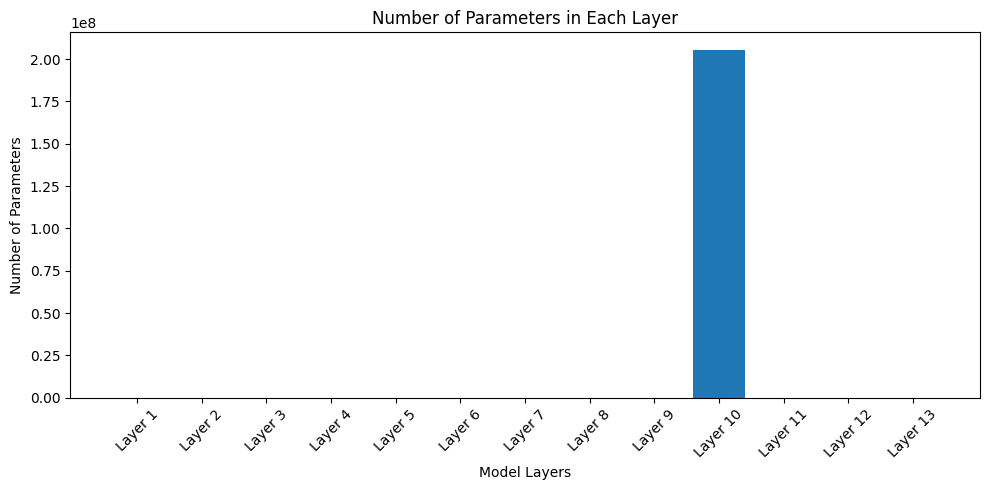

In [ ]:
# Get the model's parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = [p.numel() for p in model_parameters]

# Create labels for each layer
layer_labels = [f'Layer {i}' for i in range(1, len(params) + 1)]

# Create a bar graph
plt.figure(figsize=(10, 5))
plt.bar(layer_labels, params)
plt.xlabel('Model Layers')
plt.ylabel('Number of Parameters')
plt.title('Number of Parameters in Each Layer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the graph
plt.show()

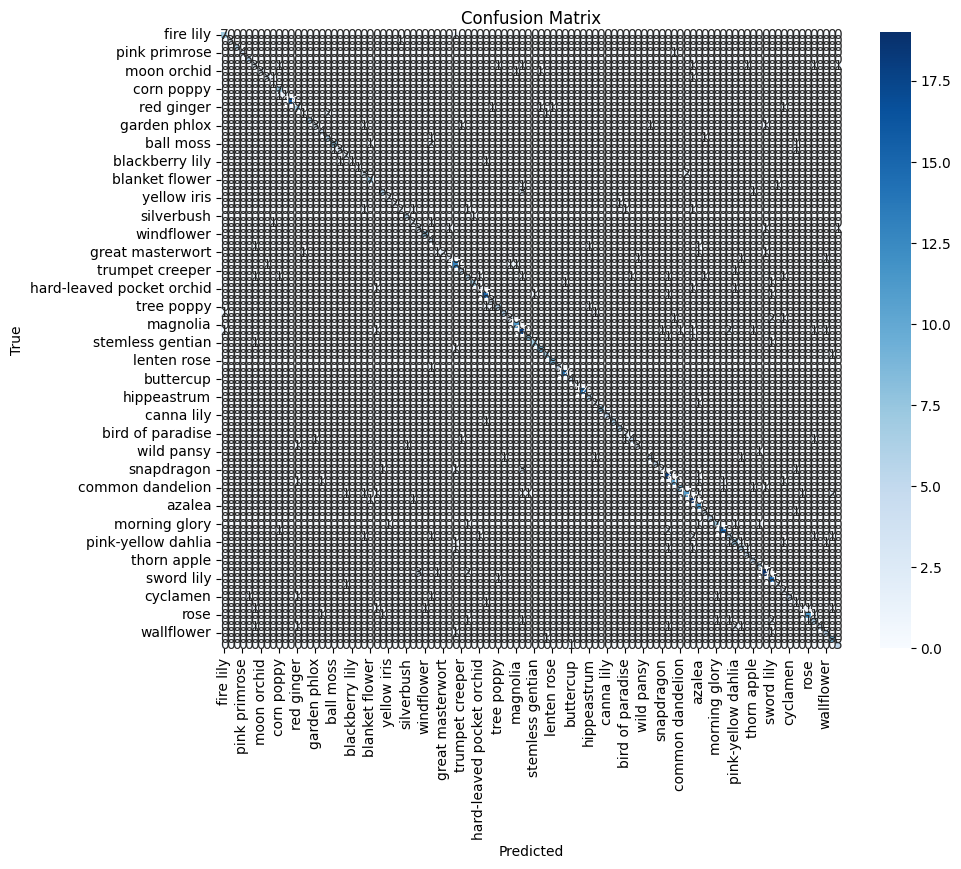

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set the model to evaluation mode
model.eval()

# Initialize variables to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to collect labels
with torch.no_grad():
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a Pandas DataFrame for visualization
cm_df = pd.DataFrame(cm, index=cat_to_name.values(), columns=cat_to_name.values())

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 6: Load the Model
At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
model = torch.load('deform.pth').to(device)
# If you also saved other attributes like optimizer state
model.state_dict()



FileNotFoundError: [Errno 2] No such file or directory: 'deform100.pth'

In [ ]:
writer.close()

In [ ]:
tensorboard --logdir==runs

NameError: name 'tensorboard' is not defined